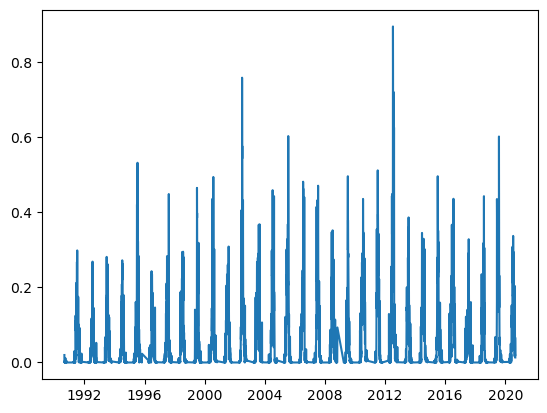

In [3]:
# Melt area timeseries supplied by NSIDC
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Read the data
df = pd.read_csv('greenland-daily-melt.csv')
# Dates
GIS_time = np.array([datetime.strptime(day,'%Y-%m-%d') for day in df['date']])
# Melt area
GIS_meltarea = df['melting_area_km2']
# Total area
GIS_totalarea = df['icesheet_area_km2']
# Melt fraction
GIS_meltfrac = GIS_meltarea/GIS_totalarea
df['melt_fraction'] = GIS_meltfrac

# Add day_of_year column to the dataframe
df['day_of_year'] = GIS_time.astype('datetime64[D]').astype(int) - GIS_time.astype('datetime64[Y]').astype(int) * 365 - (GIS_time.astype('datetime64[Y]').astype(int) // 4 - GIS_time.astype('datetime64[Y]').astype(int) // 100 + GIS_time.astype('datetime64[Y]').astype(int) // 400) + 1

# Find the dates for the climatology
tclim = (GIS_time >= datetime(1990, 9, 1)) & (GIS_time <= datetime(2020, 8, 31))
dfclim = df[tclim]

# Find the dates for the 2024 mass balance year
start_date = datetime(2023, 9, 1)
end_date = datetime(2024, 8, 31)
t2324 = (GIS_time >= start_date) & (GIS_time <= end_date)
df2324 = df[t2324]

# Plot melt area to check data is read in correctly
plt.figure()
plt.clf()
plt.plot(GIS_time[tclim],GIS_meltfrac[tclim])


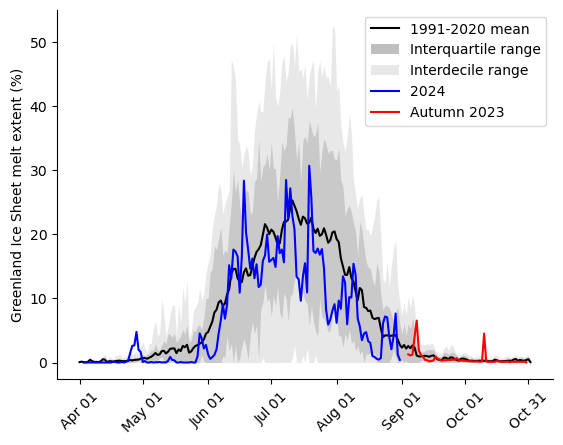

In [4]:
# Calculate the climatological average, std, interdecile, interquartlie
melt_avg = dfclim.groupby('day_of_year')['melt_fraction'].mean()
melt_std = dfclim.groupby('day_of_year')['melt_fraction'].std()
# Interquartile
q75 = dfclim.groupby('day_of_year')['melt_fraction'].apply(lambda x: np.percentile(x, 75))
q25 = dfclim.groupby('day_of_year')['melt_fraction'].apply(lambda x: np.percentile(x, 25))
melt_iqr = q75 - q25
# Interdecile
q90 = dfclim.groupby('day_of_year')['melt_fraction'].apply(lambda x: np.percentile(x, 90))
q10 = dfclim.groupby('day_of_year')['melt_fraction'].apply(lambda x: np.percentile(x, 10))
melt_idr = q90 - q10


# Plot the average melt
# Annual data starts on April 1 (March 31 for leap years) = DOY 91
# Annual data ends on October 31 (October 30 for leap years) = DOY 304
fig, ax = plt.subplots()
melt_avg_index = np.arange(91-1, 304+1)
ax.plot(melt_avg_index, 100*melt_avg, color='black', label='1991-2020 mean')

# Choose to plot by standard deviation
# ax.fill_between(melt_avg_index, np.maximum(0, 100*melt_avg - 100*melt_std), 100*melt_avg + 100*melt_std, color='gray', linewidth=0, alpha=0.5, label='±1 Std Dev')
# ax.fill_between(melt_avg_index, np.maximum(0, 100*melt_avg - 100*2*melt_std), 100*melt_avg + 100*2*melt_std, color='lightgray', linewidth=0, alpha=0.5, label='±2 Std Dev')

# Choose to plot by interquartile and interdecile
ax.fill_between(melt_avg_index, np.maximum(0, 100*melt_avg - 100*melt_iqr), 100*melt_avg + 100*melt_iqr, color='gray', linewidth=0, alpha=0.5, label='Interquartile range')
ax.fill_between(melt_avg_index, np.maximum(0, 100*melt_avg - 100*melt_idr), 100*melt_avg + 100*melt_idr, color='lightgray', linewidth=0, alpha=0.5, label='Interdecile range')

# They are actually quite similar




# Plot the 2024 melt
# 2024 data starts on March 31 (leap year) = DOY 91
# 2024 data ends on August 31 = DOY 244
melt_24_index = np.arange(91+1, 244-1)
t24 = (GIS_time >= datetime(2024,3,31)) & (GIS_time <= end_date)
df24 = df[t24]
ax.plot(melt_24_index, 100*df24['melt_fraction'], color='blue', label='2024')


# Plot the 2023 part of the 2024 mass balance year
# 2023 autumn data starts on September 1 = DOY 244
# 2023 autumn data ends on October 31 = DOY 304
melt_23_index = np.arange(244+2, 304-1)
t23 = (GIS_time >= start_date) & (GIS_time <= datetime(2024,3,31))
df23 = df[t23]
ax.plot(melt_23_index, 100*df23['melt_fraction'], color='red', label='Autumn 2023')

# Change x labels to the right dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks([90, 120, 151, 181, 212, 243, 273, 303])
plt.xticks(rotation=45)

# Nuke part of the box
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylabel('Greenland Ice Sheet melt extent (%)')
plt.legend()
plt.savefig('GrIS_melt_extent.png')
plt.savefig('GrIS_melt_extent.svg')

plt.show()